# Modeling customer churn for an e-commerce company with Python
- How to use the Lifetimes package to predict non-contractual churn risk
- It's more cost effective to retain existing customers than to acquire new ones, which is why it's important to track customers at high risk of turnover (churn) and target them with retention strategies.
- build a customer churn model based off of data from Olist, a Brazilian e-commerce site. 
  - Identify high risk customers and inform retention strategies and marketing experiments.

- There's one complication with e-commerce. While it's straightforward to measure churn for a contractual (subscription-based) business.
- Churns aren't explicitly observed in non-contractual businesses (e-commerce). 
  - The probabilistic BG/NBD model from the Lifetimes package will be used for for estimating time of customer death.
  
## working historyh  
- module name: churn_e_commerce_olist.ipynb
## Ref
https://github.com/collindching/Olist-Customer-Churn/blob/master/Olist%20churn%20risk%20model.ipynb
https://towardsdatascience.com/modeling-customer-churn-for-an-e-commerce-business-with-python-874315e688bf  
  
## Notes - Install
- pip install lifetimes

## input files

- Brazilian E-Commerce Public Dataset by Olist
  - Order Items Dataset
  - Order Dataset
  - Customers Dataset

## Load the data

In [81]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

from lifetimes.utils import *
from lifetimes import BetaGeoFitter,GammaGammaFitter
from lifetimes.plotting import plot_probability_alive_matrix, plot_frequency_recency_matrix, plot_period_transactions
from lifetimes.plotting import plot_cumulative_transactions,plot_incremental_transactions
from lifetimes.generate_data import beta_geometric_nbd_model
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases, plot_period_transactions
from lifetimes.plotting import plot_history_alive



In [3]:
orders = pd.read_csv('C:\SYUE\RecSys\Data\olist_orders_dataset.csv')


In [4]:
items = pd.read_csv('C:\SYUE\RecSys\Data\olist_order_items_dataset.csv')


In [5]:
cust = pd.read_csv('C:\SYUE\RecSys\Data\olist_customers_dataset.csv')

## RFM
- The Lifetimes package relies on recency-frequency-monetary (RFM) analysis to model churn and customer lifetime value (CLV). 
- To make our models, we'll need a a dataframe that consists of recency, frequency, and monetary columns. T
  - Recency: time between initial purchase and most recent (last) purchase
  - Frequency: number of repeat purchases made by a customer (total purchases - 1)
  = Monetary: total spent on purchases

## Building the dataset

- Customer ID information will come from cust. 
- Order date will come from orders. 
- Price will come from items.

In [6]:
print(cust.columns)

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')


## customer_id vs  customer_unique_id
- Customer_id is a customer ID token that is generated for every order. 
  - If the same customer makes multiple orders, he has multiple customer_id identifiers. What we want to use for this 
- Customer_unique_id is unique to each purchaser and can be used to analysis and track their purchases over time.
- Here is the distribution of purchases made by customers.

In [7]:
"""
93099 customer_unique_id  with size =1 (no repeat/duplicate)  
2745  customer_unique_id  with size = 2 ( repeat twice)
"""
cust.groupby('customer_unique_id').size().value_counts()

1     93099
2      2745
3       203
4        30
5         8
6         6
7         3
17        1
9         1
dtype: int64

In [9]:
"""
customer_id' + 'customer_unique_id' is unique in cust
"""
cust.groupby(['customer_id', 'customer_unique_id']).size().value_counts()

1    99441
dtype: int64

In [11]:
"""
customer_id is unique in cust
"""
cust.groupby(['customer_id']).size().value_counts()

1    99441
dtype: int64

In [10]:
cust.shape

(99441, 5)

In [12]:
orders.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')

In [13]:
orders.shape

(99441, 8)

In [14]:
"""
customer_id is unique in orders
"""
orders.groupby('customer_id').size().value_counts()

1    99441
dtype: int64

In [15]:
cust.groupby('customer_unique_id').size().value_counts().sum()

96096

In [38]:
orders = pd.merge(orders,cust[['customer_id','customer_unique_id']],on='customer_id')
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6


In [39]:
orders.shape

(99441, 9)

In [23]:
cust_dup =  cust[cust.customer_unique_id.duplicated()]

In [24]:
cust_dup.shape 

(3345, 5)

In [25]:
cust_dup.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
679,c57b4b6f3719475543b721e720a526ad,b6c083700ca8c135ba9f0f132930d4e8,8686,suzano,SP
1463,9f6f3da49e2d46e3a7529f5e3c25ecce,a40096fc0a3862e9e12bc55b5f8e6ab2,20561,rio de janeiro,RJ
1607,299f7b5125c8fbe1761a1b320c34fc7d,b8b3c435a58aebd788a477bed8342910,95585,arroio do sal,RS
2811,226d59f9f4b98e228b689eea45d03a6d,66980c3775537536f77b434d74e520f5,30290,belo horizonte,MG
3198,b1253701171dfb298f52a221f824e45b,788313d21c3507fe890921f6e17aa679,11070,santos,SP


In [26]:
 orders [ (orders.customer_id == 'f7c5afab273b47ab517e096e0219b932') | 
         (orders.customer_id == 'c57b4b6f3719475543b721e720a526ad') ].head()


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
54472,0be5691eb4c245d190a1e194494f754d,f7c5afab273b47ab517e096e0219b932,delivered,2017-09-05 15:32:33,2017-09-05 15:50:35,2017-09-06 19:37:44,2017-09-11 22:19:57,2017-09-28 00:00:00
68560,3c8194a8d47f5852dcd52ccbf364596e,c57b4b6f3719475543b721e720a526ad,delivered,2017-11-27 12:44:25,2017-11-27 12:56:18,2017-11-30 19:25:50,2017-12-01 17:05:02,2017-12-11 00:00:00


In [27]:
items.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')

In [34]:
items.groupby('order_id').size().value_counts() 

1     88863
2      7516
3      1322
4       505
5       204
6       198
7        22
10        8
8         8
12        5
11        4
9         3
20        2
14        2
15        2
13        1
21        1
dtype: int64

In [35]:
items[items.order_id.duplicated()].head()


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
14,0008288aa423d2a3f00fcb17cd7d8719,2,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,2018-02-21 02:55:52,49.90,13.37
33,00143d0f86d6fbd9f9b38ab440ac16f5,2,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.10
34,00143d0f86d6fbd9f9b38ab440ac16f5,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.10
43,001ab0a7578dd66cd4b0a71f5b6e1e41,2,0b0172eb0fd18479d29c3bc122c058c2,5656537e588803a555b8eb41f07a944b,2018-01-04 02:33:42,24.89,17.63
44,001ab0a7578dd66cd4b0a71f5b6e1e41,3,0b0172eb0fd18479d29c3bc122c058c2,5656537e588803a555b8eb41f07a944b,2018-01-04 02:33:42,24.89,17.63


In [36]:
items[items.order_id == '0008288aa423d2a3f00fcb17cd7d8719'].head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
13,0008288aa423d2a3f00fcb17cd7d8719,1,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,2018-02-21 02:55:52,49.9,13.37
14,0008288aa423d2a3f00fcb17cd7d8719,2,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,2018-02-21 02:55:52,49.9,13.37


In [37]:
items[items.order_id == '00143d0f86d6fbd9f9b38ab440ac16f5'].head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
32,00143d0f86d6fbd9f9b38ab440ac16f5,1,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
33,00143d0f86d6fbd9f9b38ab440ac16f5,2,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
34,00143d0f86d6fbd9f9b38ab440ac16f5,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1


## items dataset

 - Each item in an order gets its separate row
 - The price column refers cumulative order purchase rather than individual item price
 - keep the first item from each order

In [41]:
items.drop_duplicates('order_id',keep='first',inplace=True)

In [42]:
"""
order_id is unique in orders
"""
orders.groupby('order_id').size().value_counts()

1    99441
dtype: int64

In [43]:
items.groupby('order_id').size().value_counts()

1    98666
dtype: int64

In [44]:
items.shape

(98666, 7)

## Create transaction_data
-  Convert timestamp to date; only need the day

In [45]:
transaction_data = pd.merge(orders,items,'inner','order_id')
transaction_data = transaction_data[['customer_unique_id','order_purchase_timestamp','price']]
transaction_data['date'] = pd.to_datetime(transaction_data['order_purchase_timestamp']).dt.date
transaction_data = transaction_data.drop('order_purchase_timestamp',axis=1)
transaction_data.head()

,customer_unique_id,price,date
0,7c396fd4830fd04220f754e42b4e5bff,29.99,2017-10-02
1,af07308b275d755c9edb36a90c618231,118.70,2018-07-24
2,3a653a41f6f9fc3d2a113cf8398680e8,159.90,2018-08-08
3,7c142cf63193a1473d2e66489a9ae977,45.00,2017-11-18
4,72632f0f9dd73dfee390c9b22eb56dd6,19.90,2018-02-13


In [47]:
from lifetimes.datasets import load_transaction_data 
from lifetimes.utils import summary_data_from_transaction_data

In [ ]:
### summary_data_from_transaction_data
- A utility from lifetimes package
- Before involing the utility, need to import the following packages 
  from lifetimes.datasets import load_transaction_data 
  from lifetimes.utils import summary_data_from_transaction_data

In [64]:
summary = summary_data_from_transaction_data(transaction_data,'customer_unique_id','date',monetary_value_col='price',)
summary.describe()

,frequency,recency,T,monetary_value
count,95420.000000,95420.000000,95420.000000,95420.000000
mean,0.024198,2.683389,246.184846,2.474897
std,0.178936,25.263074,153.656402,26.579606
min,0.000000,0.000000,5.000000,0.000000
25%,0.000000,0.000000,122.000000,0.000000
50%,0.000000,0.000000,227.000000,0.000000
75%,0.000000,0.000000,356.000000,0.000000
max,15.000000,633.000000,729.000000,1999.990000


In [49]:
print(transaction_data.date.max())
print(transaction_data.date.min())

2018-09-03
2016-09-04


In [65]:
summary.head()

,frequency,recency,T,monetary_value
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,116.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,119.0,0.0
0000f46a3911fa3c0805444483337064,0.0,0.0,542.0,0.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,326.0,0.0
0004aac84e0df4da2b147fca70cf8255,0.0,0.0,293.0,0.0


In [55]:
transaction_data[ (transaction_data.customer_unique_id == '0000366f3b9a7992bf8c76cfdf3221e2')
                | (transaction_data.customer_unique_id ==  '004288347e5e88a27ded2bb23747066c')].head()


,customer_unique_id,price,date
33396,004288347e5e88a27ded2bb23747066c,229.99,2017-07-27
39730,004288347e5e88a27ded2bb23747066c,87.90,2018-01-14
52389,0000366f3b9a7992bf8c76cfdf3221e2,129.90,2018-05-10


In [58]:
import datetime
from datetime import datetime, timedelta, date
import time 


In [61]:
date1 = date(2016, 9,4)
date2 = date(2018, 5,10)
print ( (date2 - date1).days )

613


In [66]:
summary[ (summary.customer_unique_id == '0000366f3b9a7992bf8c76cfdf3221e2')
                | (summary.customer_unique_id ==  '004288347e5e88a27ded2bb23747066c')].head()

AttributeError: 'DataFrame' object has no attribute 'customer_unique_id'

In [67]:
summary.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95420 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 4 columns):
frequency         95420 non-null float64
recency           95420 non-null float64
T                 95420 non-null float64
monetary_value    95420 non-null float64
dtypes: float64(4)
memory usage: 6.1+ MB


In [68]:
summary.head()

,frequency,recency,T,monetary_value
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,116.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,119.0,0.0
0000f46a3911fa3c0805444483337064,0.0,0.0,542.0,0.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,326.0,0.0
0004aac84e0df4da2b147fca70cf8255,0.0,0.0,293.0,0.0


In [70]:
summary. loc[ '0000366f3b9a7992bf8c76cfdf3221e2']

frequency           0.0
recency             0.0
T                 116.0
monetary_value      0.0
Name: 0000366f3b9a7992bf8c76cfdf3221e2, dtype: float64

In [71]:
summary. loc[ '004288347e5e88a27ded2bb23747066c']

frequency           1.0
recency           171.0
T                 403.0
monetary_value     87.9
Name: 004288347e5e88a27ded2bb23747066c, dtype: float64

In [73]:
date1 = date(2016, 9,4)
date2 = date(2016, 9,5)
print ( (date2 - date1).days )

1


In [74]:
summary['frequency'].value_counts()

0.0     93335
1.0      1927
2.0       126
3.0        18
4.0         6
5.0         5
6.0         2
15.0        1
Name: frequency, dtype: int64


## Visualizing the RFM DataFrame
- Use the Beta-Geometric/NBD (BG/NBD) model for customer churn
  -  The BG/NBD model is an adaptation of the Pareto/NBD model 
     - Both models describe repeat purchasing patterns in businesses where customer turnover is unobserved 
        - The BG/NBD is much more computationally feasible.

- Assumptions of the BG/NBD model:

  - A customer's relationship has two phases: "alive" for an unobserved period of time, then "dead"
  - While alive, the number of transactions made by a customer follows a Poisson distribution with transaction rate 
    lambda
    - Heterogeneity in lambda follows a gamma distribution
      - After any transaction, a customer dies with probability p; 
        - The probability that a customer dies after a number of transactions follows a geometric distribution
  - p follows a beta distribution
    - Lambda and p vary independently across customers

In [76]:
from lifetimes import  BetaGeoFitter

In [77]:
"""
Required to import BetaGeoFitter 
 from lifetimes import  BetaGeoFitter
"""
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

<lifetimes.BetaGeoFitter: fitted with 95420 subjects, a: 2.07, alpha: 65.86, b: 0.35, r: 0.02>

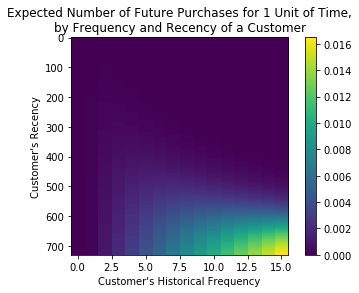

In [82]:
plot_frequency_recency_matrix(bgf)

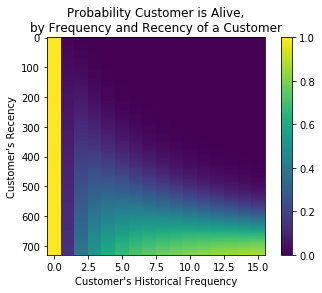

In [83]:

plot_probability_alive_matrix(bgf);

## Training a model and evaluating model performance
Next we want to evaluate the model to see how well it performs in the future. 
- Split the data into a training (calibration) period and a holdout (observation) period 
  - Train the BG/NBD model and evaluate performance with four plots that Peter Fader outlines in this talk (@ 26:10).
    These plots are:

    1) Calibration period histogram: does the model fit the training data?    
    2) Cumulative transaction plot: does the model predict cumulative sales well?    
    3) Incremental transaction plot: does the model capture the overall trend in transactions?    
    4) Conditional expectations plot: can the model predict the number of purchases a customer will make based on the training data?

### 1) Calibration period histogram¶

C:\ProgramData\Anaconda3\lib\site-packages\lifetimes\generate_data.py:54: RuntimeWarning: overflow encountered in double_scalars
  next_purchase_in = random.exponential(scale=1.0 / l)


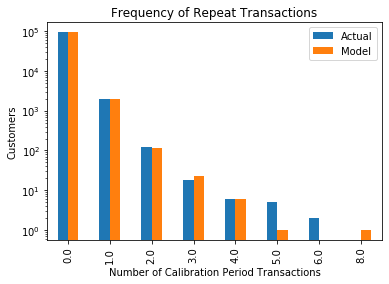

In [86]:
plot_period_transactions(bgf).set_yscale('log');

C:\ProgramData\Anaconda3\lib\site-packages\lifetimes\generate_data.py:54: RuntimeWarning: divide by zero encountered in double_scalars
  next_purchase_in = random.exponential(scale=1.0 / l)
C:\ProgramData\Anaconda3\lib\site-packages\lifetimes\generate_data.py:54: RuntimeWarning: overflow encountered in double_scalars
  next_purchase_in = random.exponential(scale=1.0 / l)


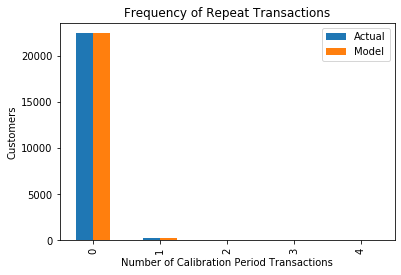

In [99]:

plot_period_transactions(bgf)

### 2) Cumulative transaction plot

In [88]:
summary_cal_holdout = calibration_and_holdout_data(transaction_data, 'customer_unique_id', 'date',
                                        calibration_period_end='2017-09-03',
                                        observation_period_end='2018-09-03' )

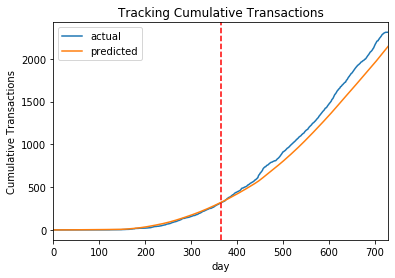

In [89]:
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_cumulative_transactions(bgf,transaction_data,'date','customer_unique_id',730,365);

### 3) Incremental transaction plot

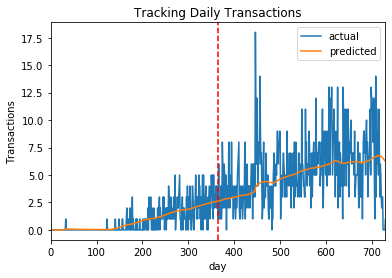

In [90]:
plot_incremental_transactions(bgf,transaction_data,'date','customer_unique_id',730,365);

### 4) Conditional expectations plot¶

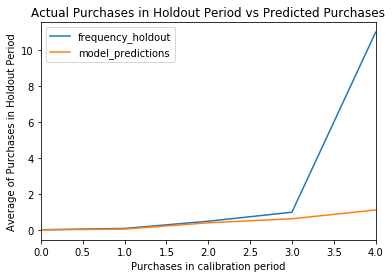

In [91]:
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout);

### TRansaction analysis

- Less than 1% of customers have made four or more purchases
  - so there's not much data for the BG/NBD model to learn about customers who have made many repeat transactions.
  - In practice, might consider collecting more data 
    - if proceed with modeling customer churn

In [92]:

cust.groupby('customer_unique_id').size().value_counts()

1     93099
2      2745
3       203
4        30
5         8
6         6
7         3
17        1
9         1
dtype: int64

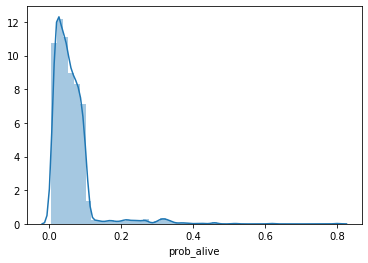

In [93]:

df = summary[summary['frequency']>0]
df['prob_alive'] = bgf.conditional_probability_alive(df['frequency'],df['recency'],df['T'])
sns.distplot(df['prob_alive']);

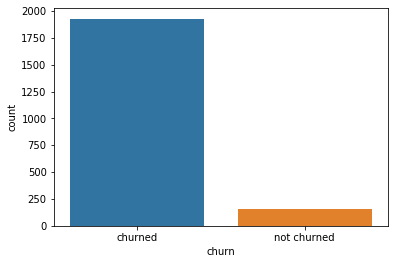

In [94]:
df['churn'] = ['churned' if p < .1 else 'not churned' for p in df['prob_alive']]
sns.countplot(df['churn']);

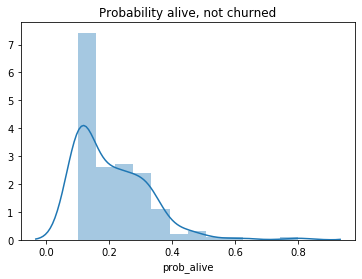

In [95]:
sns.distplot(df[df['churn']=='not churned']['prob_alive']).set_title('Probability alive, not churned');

In [96]:
df['churn'][(df['prob_alive']>=.1) & (df['prob_alive']<.2)] = "high risk"
df['churn'].value_counts()

churned        1928
high risk        84
not churned      73
Name: churn, dtype: int64

In [98]:
from lifetimes.datasets import load_cdnow_summary

In [ ]:
data = load_cdnow_summary(index_col=[0])